In [18]:
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import random

In [2]:
class Value:
    def __init__(self,data,_children = (),_op = '',label =''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0
        self._op = _op
        self.label = label
        self._backward = lambda:None
    def __repr__(self):
        return f"Value(data) = {self.data}"
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data+other.data,(self,other),'+')
        def _backward():
            self.grad += 1*out.grad
            other.grad += 1*out.grad
        out._backward = _backward
        return out
    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad   # derivative wrt self
            other.grad += self.data * out.grad   # derivative wrt other
        out._backward = _backward

        return out
    def __rmul__(self,other):
        return self*other
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self + (-other)

    def __rsub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return other + (-self)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other*(self.data**(other-1))*out.grad
        out._backward = _backward

        return out
    def __neg__(self):
        return self*-1
    def __truediv__(self,other):
        return self*other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self, ),'tanh')
        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self, ),'exp')
        def _backward():
            self.grad += out.data*out.grad
        out._backward = _backward
        return out
    
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [3]:
from graphviz import Digraph

In [4]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

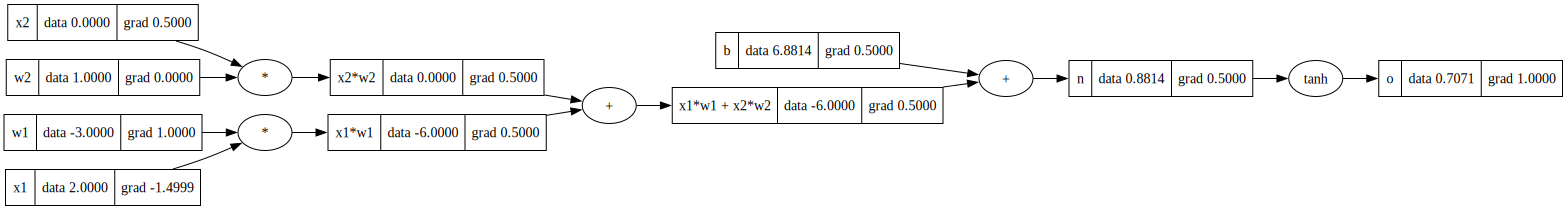

In [5]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8814, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh();o.label='o'

o.backward()
draw_dot(o)

In [6]:
a = Value(2)
b = Value(2)
a-b

Value(data) = 0

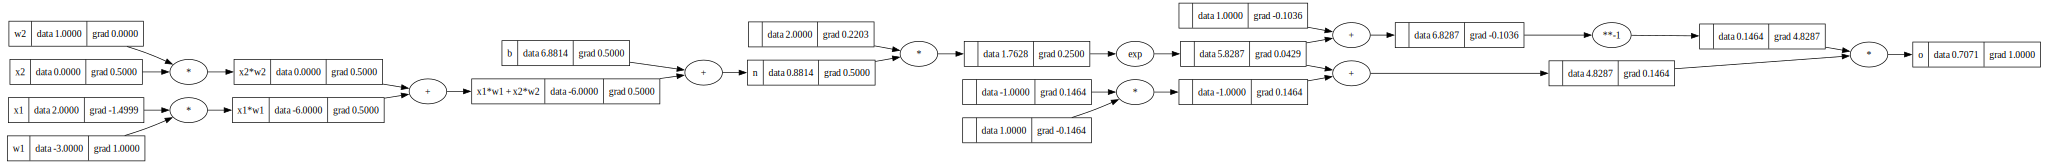

In [8]:
import torch

In [9]:
x1 = torch.Tensor([2.0]).double()     ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()     ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()    ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()     ; w2.requires_grad = True
b  = torch.Tensor([6.881375870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2:', x2.grad.item())
print('w2:', w2.grad.item())
print('x1:', x1.grad.item())
print('w1:', w1.grad.item())


0.7071078824962277
---
x2: 0.499998442511701
w2: 0.0
x1: -1.499995327535103
w1: 0.999996885023402


In [84]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [183]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data) = -0.6666542163485886

In [184]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0,-1.0,-1.0,1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data) = -0.6666542163485886,
 Value(data) = 0.4888624141044224,
 Value(data) = 0.29587860026009977,
 Value(data) = -0.5328821579413828]

In [209]:
for k in range(1000):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout-ygt)**2 for ygt,yout in zip(ys,ypred)),Value(0))
    
    #zero grad
    for p in n.parameters():
        p.grad = 0.0
        
    #backward pass
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data+=-0.01*p.grad
        
    print(k,loss.data)

0 0.00022866506733362296
1 0.00022864152396649277
2 0.00022861798538803402
3 0.00022859445159679857
4 0.00022857092259133356
5 0.00022854739837018786
6 0.00022852387893190963
7 0.000228500364275047
8 0.00022847685439814937
9 0.0002284533492997709
10 0.00022842984897846087
11 0.0002284063534327748
12 0.00022838286266126023
13 0.00022835937666247066
14 0.0002283358954349639
15 0.0002283124189772929
16 0.00022828894728800845
17 0.0002282654803656676
18 0.00022824201820882873
19 0.00022821856081604684
20 0.00022819510818588017
21 0.0002281716603168864
22 0.00022814821720762042
23 0.0002281247788566414
24 0.00022810134526251094
25 0.00022807791642379138
26 0.0002280544923390443
27 0.00022803107300682364
28 0.0002280076584256944
29 0.00022798424859422122
30 0.00022796084351096678
31 0.0002279374431744928
32 0.00022791404758336071
33 0.00022789065673614053
34 0.00022786727063139442
35 0.0002278438892676888
36 0.00022782051264359234
37 0.00022779714075766663
38 0.00022777377360848217
39 0.0002

363 0.0002204223714906654
364 0.00022040047538981992
365 0.0002203785835865574
366 0.0002203566960796206
367 0.00022033481286775995
368 0.00022031293394971115
369 0.0002202910593242202
370 0.0002202691889900241
371 0.00022024732294587823
372 0.00022022546119051996
373 0.00022020360372269497
374 0.00022018175054115279
375 0.00022015990164463817
376 0.0002201380570318896
377 0.0002201162167016703
378 0.0002200943806527138
379 0.0002200725488837764
380 0.0002200507213936015
381 0.00022002889818094513
382 0.0002200070792445425
383 0.0002199852645831591
384 0.00021996345419554293
385 0.0002199416480804358
386 0.0002199198462365973
387 0.00021989804866277845
388 0.0002198762553577339
389 0.00021985446632020642
390 0.00021983268154896255
391 0.00021981090104274852
392 0.0002197891248003201
393 0.00021976735282043256
394 0.00021974558510184168
395 0.00021972382164329944
396 0.00021970206244356958
397 0.0002196803075014074
398 0.0002196585568155654
399 0.00021963681038480383
400 0.0002196150682

816 0.00021092486343024606
817 0.0002109047924664343
818 0.0002108847252769278
819 0.0002108646618606656
820 0.00021084460221658667
821 0.00021082454634363944
822 0.00021080449424076164
823 0.00021078444590690048
824 0.00021076440134099205
825 0.00021074436054198512
826 0.00021072432350882154
827 0.00021070429024045044
828 0.0002106842607358093
829 0.0002106642349938491
830 0.00021064421301351098
831 0.00021062419479373948
832 0.0002106041803334921
833 0.0002105841696317046
834 0.00021056416268732596
835 0.00021054415949930922
836 0.00021052416006658972
837 0.00021050416438812863
838 0.0002104841724628763
839 0.00021046418428976633
840 0.00021044419986776107
841 0.00021042421919580638
842 0.00021040424227285193
843 0.00021038426909785339
844 0.0002103642996697545
845 0.00021034433398750774
846 0.0002103243720500664
847 0.00021030441385638883
848 0.00021028445940541265
849 0.00021026450869610785
850 0.00021024456172741903
851 0.00021022461849830272
852 0.00021020467900770582
853 0.00021

In [210]:
ypred

[Value(data) = 0.994390335893248,
 Value(data) = -0.9970180207359097,
 Value(data) = -0.991338604269198,
 Value(data) = 0.9904118105696615]